In [11]:
import tensorflow as tf
import numpy
import matplotlib.pyplot as plot
from keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array

Скачиваем данные для обучения и преобразуем их для использования с tf

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels),(test_images, test_labels) = mnist.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

Введём дополнительные функции для упрощения обучения моделей:
- val_model - проверяет обученную модель на тестовых данных и выводит статистику
- compile_and_fit - принимает модель и оптимизатор, и обучает модель

In [ ]:
def val_model(model):
    val_loss, val_acc = model.evaluate(test_images, test_labels, verbose=0)
    print('val_accuracy:', val_acc, 'val_loss', val_loss)

def compile_and_fit(model, opt=tf.keras.optimizers.Adam()):
    with tf.device("/GPU:0"):
        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(train_images, train_labels, epochs=5, batch_size=128, verbose=0)
        val_model(model)
        return history

Добавим функции для построения графиков:

In [6]:
def init_plot(name=''):
    plot.rcParams["figure.figsize"] = (14, 6)
    figure, plot_arr = plot.subplots(1, 2)
    plot_arr[0].set_title("loss")
    plot_arr[1].set_title("accuracy")
    return plot_arr

def append_to_plot(plot_arr, history, lbl=''):
    plot_arr[0].plot(history.history["loss"], label=lbl)
    plot_arr[1].plot(history.history["accuracy"], label=lbl)

def finalize_plot(plot_arr):
    plot_arr[0].legend()
    plot_arr[1].legend()
    plot.show()
    plot.clf()
plot.clf()

<Figure size 640x480 with 0 Axes>

optimizers - Функция которая возвращает список оптимизаторов 

Оптимизаторы:
- Adadelta со стандартными параметрами
- Adadelta с learning_rate увеличенным в 3 раза
- Adagrad со стандартными параметрами
- Adam со стандартными параметрами
- Adam с параметром amsgrad
- Adamax со стандартными параметрами
- Adamax с параметром ema
- Ftrl со стандартными параметрами
- Nadam со стандартными параметрами
- RMSprop со стандартными параметрами
- RMSprop с параметром centered
- SGD со стандартными параметрами
- SGD с параметром nesterov

Все оптимизаторы создаю с ```jit_compile=True``` просто чтобы ускорить оптимизацию под GPU, на работу оптимизаторов влиять не должно.

In [35]:
def optimizers():
    optimizers = [
        (tf.keras.optimizers.Adadelta(jit_compile=True), 'Default Adadelta'),
        (tf.keras.optimizers.Adadelta(jit_compile=True, learning_rate=0.003), 'Adadelta 3x l.r'),
        (tf.keras.optimizers.Adagrad(jit_compile=True), 'Default Adagrad'),
        (tf.keras.optimizers.Adam(jit_compile=True), 'Default Adam'),
        (tf.keras.optimizers.Adam(jit_compile=True, amsgrad=True), 'Adam with amsgrad'),
        (tf.keras.optimizers.Adamax(jit_compile=True), 'Default Adamax'),
        (tf.keras.optimizers.Adamax(jit_compile=True, use_ema=True), 'Adamax ema'),
        (tf.keras.optimizers.Ftrl(jit_compile=True), 'Default Ftrl'),
        (tf.keras.optimizers.Nadam(jit_compile=True), 'Default Nadam'),
        (tf.keras.optimizers.RMSprop(jit_compile=True), 'Default RMSprop'),
        (tf.keras.optimizers.RMSprop(jit_compile=True, centered=True), 'RMSprop centered'), # больше времени
        (tf.keras.optimizers.SGD(jit_compile=True), 'Default SGD'),
        (tf.keras.optimizers.SGD(jit_compile=True, nesterov=True), 'SGD nesterov')
    ]
    return optimizers

Обучим модели со всеми оптимизаторами из функции ```optimizers``` и построим сравнительный график зависимости точности и потерь от числа эпох:

Default Adadelta
val_accuracy: 0.48919999599456787 val_loss 1.8793278932571411
Adadelta 3x l.r
val_accuracy: 0.8102999925613403 val_loss 1.1613199710845947
Default Adagrad
val_accuracy: 0.8758999705314636 val_loss 0.5347013473510742
Default Adam
val_accuracy: 0.9757000207901001 val_loss 0.07858090102672577
Adam with amsgrad
val_accuracy: 0.9782000184059143 val_loss 0.06862875074148178
Default Adamax
val_accuracy: 0.96670001745224 val_loss 0.11308630555868149
Adamax ema
val_accuracy: 0.9666000008583069 val_loss 0.11445755511522293
Default Ftrl
val_accuracy: 0.2102999985218048 val_loss 2.295834541320801
Default Nadam
val_accuracy: 0.9778000116348267 val_loss 0.07086475938558578
Default RMSprop
val_accuracy: 0.9753000140190125 val_loss 0.07996248453855515
RMSprop centered
val_accuracy: 0.977400004863739 val_loss 0.07242725044488907
Default SGD
val_accuracy: 0.9111999869346619 val_loss 0.3225327730178833
SGD nesterov
val_accuracy: 0.9114999771118164 val_loss 0.326027512550354


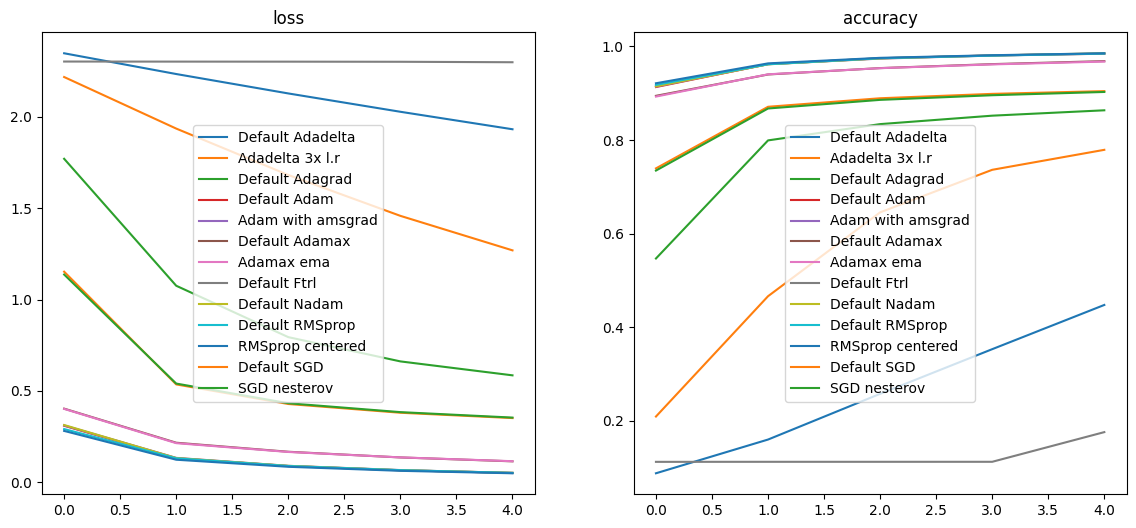

<Figure size 1400x600 with 0 Axes>

In [37]:
plot_arr = init_plot("Optimizers with default params")
for opt, descr in optimizers():
    print(descr)
    hist = compile_and_fit(Sequential([
        Flatten(),
        Dense(256, activation='relu'),
        Dense(10, activation='softmax'),
    ]),
    opt)
    append_to_plot(plot_arr, hist, descr)
finalize_plot(plot_arr)

Можно заметить что наиболее эффективными оказались следующие оптимизаторы (точность не менее 95%):
- Adam
- Adamax
- Nadam
- RMSprop

Также можно заметить что:
- Увеличенный learning_rate улучшает результаты обучения при использовании Adadelta
- Параметр amsgrad применённый к Adam не сильно меняет результаты обучения
- Параметр ema примененный к Adamax не сильно меняет результаты обучения
- Параметр centered примененный к RMSprop не сильно меняет результаты обучения

Добавим в исходную модель скрытый слой с 256 тензорами:

Default Adadelta
val_accuracy: 0.5791000127792358 val_loss 1.8797861337661743
Adadelta 3x l.r
val_accuracy: 0.8131999969482422 val_loss 1.009383201599121
Default Adagrad
val_accuracy: 0.8830999732017517 val_loss 0.4611911475658417
Default Adam
val_accuracy: 0.9793999791145325 val_loss 0.06593012809753418
Adam with amsgrad
val_accuracy: 0.9787999987602234 val_loss 0.0773928314447403
Default Adamax
val_accuracy: 0.9742000102996826 val_loss 0.08421932905912399
Adamax ema
val_accuracy: 0.9763000011444092 val_loss 0.0785023644566536
Default Ftrl
val_accuracy: 0.11349999904632568 val_loss 2.301961898803711
Default Nadam
val_accuracy: 0.9776999950408936 val_loss 0.07407373934984207
Default RMSprop
val_accuracy: 0.9772999882698059 val_loss 0.07494361698627472
RMSprop centered
val_accuracy: 0.9707000255584717 val_loss 0.10478110611438751
Default SGD
val_accuracy: 0.9211999773979187 val_loss 0.2823023796081543
SGD nesterov
val_accuracy: 0.9214000105857849 val_loss 0.2797190546989441


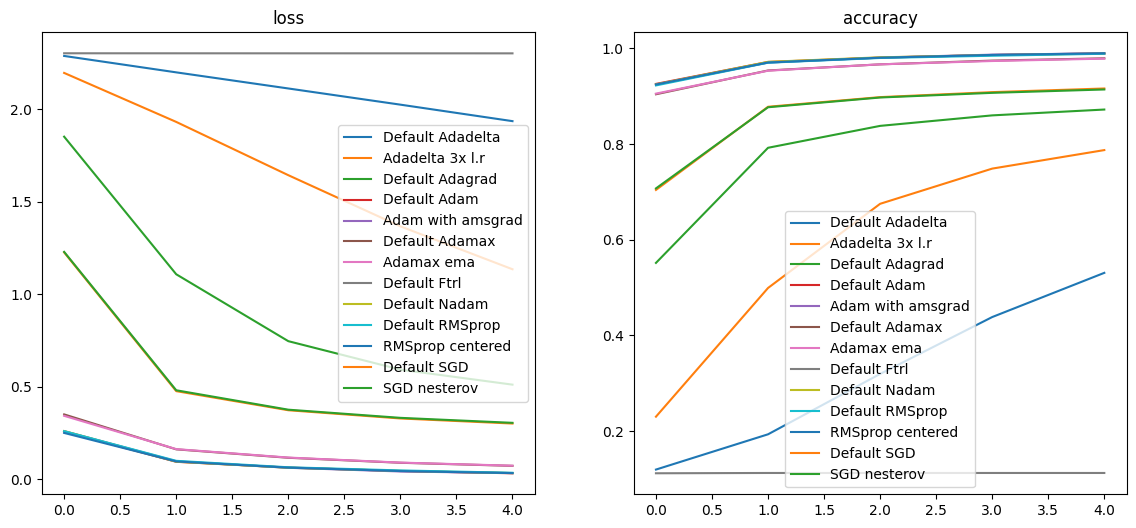

<Figure size 1400x600 with 0 Axes>

In [36]:
plot_arr = init_plot("Optimizers with default params")
for opt, descr in optimizers():
    print(descr)
    hist = compile_and_fit(Sequential([
        Flatten(),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(10, activation='softmax'),
    ]),
    opt)
    append_to_plot(plot_arr, hist, descr)
finalize_plot(plot_arr)

Можно заметить, что в среднем точность увеличилась, а потери уменьшились

Изменим число тензоров в скрытом слое с 256 на 784 (29x29):

Default Adadelta
val_accuracy: 0.7384999990463257 val_loss 1.5787222385406494
Adadelta 3x l.r
val_accuracy: 0.8449000120162964 val_loss 0.8214528560638428
Default Adagrad
val_accuracy: 0.8859000205993652 val_loss 0.4970870614051819
Default Adam
val_accuracy: 0.9818000197410583 val_loss 0.059500157833099365
Adam with amsgrad
val_accuracy: 0.9790999889373779 val_loss 0.06630151718854904
Default Adamax
val_accuracy: 0.9742000102996826 val_loss 0.08643005788326263
Adamax ema
val_accuracy: 0.9753000140190125 val_loss 0.08372274041175842
Default Ftrl
val_accuracy: 0.21040000021457672 val_loss 2.2955024242401123
Default Nadam
val_accuracy: 0.9810000061988831 val_loss 0.060934025794267654
Default RMSprop
val_accuracy: 0.9779999852180481 val_loss 0.07295786589384079
RMSprop centered
val_accuracy: 0.9796000123023987 val_loss 0.06595802307128906
Default SGD
val_accuracy: 0.9151999950408936 val_loss 0.31312644481658936
SGD nesterov
val_accuracy: 0.9168999791145325 val_loss 0.3118760585784912


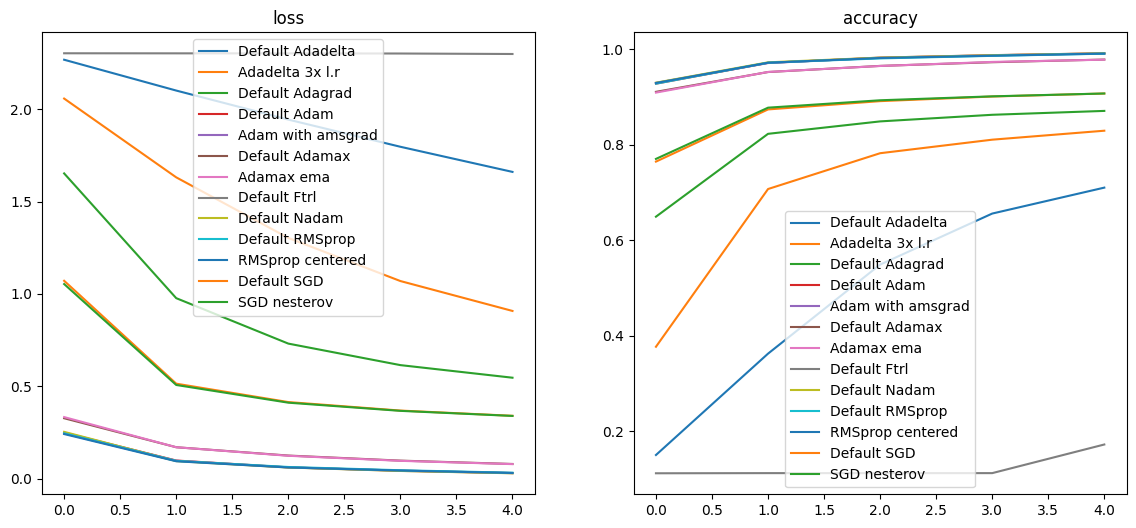

<Figure size 1400x600 with 0 Axes>

In [38]:
plot_arr = init_plot("Optimizers with default params")
for opt, descr in optimizers():
    print(descr)
    hist = compile_and_fit(Sequential([
        Flatten(),
        Dense(784, activation='relu'),
        Dense(10, activation='softmax'),
    ]),
    opt)
    append_to_plot(plot_arr, hist, descr)
finalize_plot(plot_arr)

Можно заметить, что результаты относительно изначальной модели улучшились, однако по сравнению с моделью 2 результаты хуже, времени же на обучение уходит куда больше.

Введём функцию ```read_image``` для чтения изображения из файловой системы и преобразования для работы с tf

Введём функцию ```fit_and_eval``` для обучения модели и предсказания результатов по переданным изображениям

Далее считаем две картинки, на которых изображены цифры от 2 до 5. Отобразим их на графиках и прогоним через модель (используем 2 модель):

2 [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
3 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
4 [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
5 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


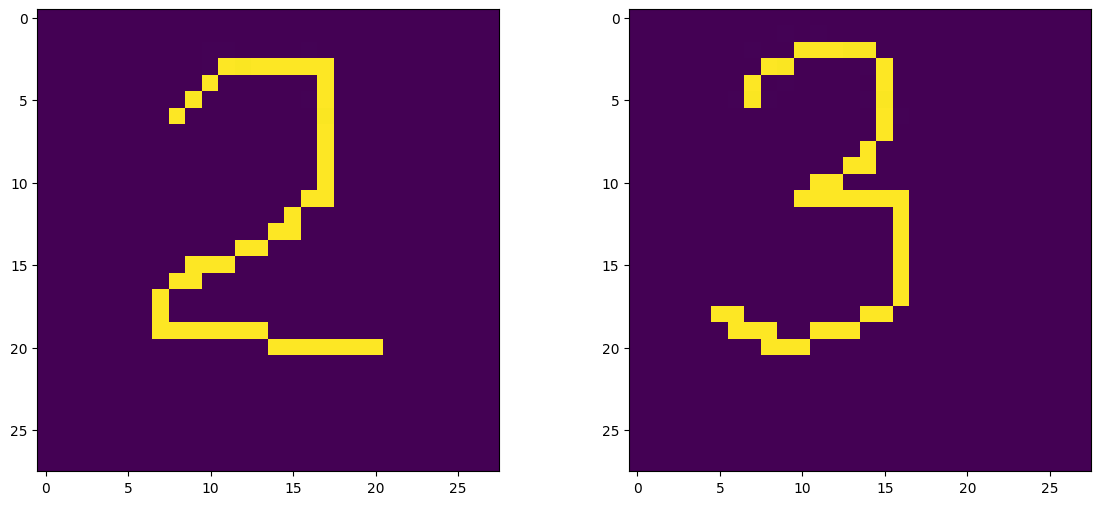

In [42]:
def read_image(filepath):
    image = 255 - (img_to_array(load_img(filepath, color_mode="grayscale"))).astype(int)
    h, w = image.shape[:2]
    return image.reshape(h, w)

def fit_and_eval(model, images):
    with tf.device("/GPU:0"):
        model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(train_images, train_labels, epochs=5, batch_size=128, verbose=0)
        for img in images:
            predict = model.predict(numpy.expand_dims(img[0], axis=0), verbose=0)
            print(img[1], numpy.round(predict))

custom_images = []
for x in range(2, 6):
    custom_images.append([read_image('./' + str(x) +'.png'), x])

plot.rcParams["figure.figsize"] = (14, 6)
figure, plot_arr = plot.subplots(1, 2)
plot_arr[0].imshow(custom_images[0][0])
plot_arr[1].imshow(custom_images[1][0])

fit_and_eval(Sequential([
    Flatten(),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax'),
]),
custom_images)